# Višestruka regresija za analizu i predikciju simptoma PCOS-a 


Importujemo glavne biblioteke koje koristimo u projektu

In [2]:
import warnings
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from helper import *

### Učitavanje prikupljenih podataka i njihov prikaz

Učitavamo podatke iz Kaggle seta podataka.  Podaci uključuju medicinske parametre (BMI, insulin, hormoni, simptomi) i 
sadrže informacije o ženama sa PCOS-om. 

In [3]:
df = pd.read_excel("data/data.xlsx", sheet_name="Full_new")
print(df.head())

   Sl. No  Patient File No.  PCOS(Y/N)  Age(yrs)  Weight(kg)  Height(cm)  \
0       1                 1          0      28.0        44.6       152.0   
1       2                 2          0      36.0        65.0       161.5   
2       3                 3          1      33.0        68.8       165.0   
3       4                 4          0      37.0        65.0       148.0   
4       5                 5          0      25.0        52.0       161.0   

         BMI  Blood Group  Pulse rate(bpm)  RR (breaths/min)  ...  \
0  19.304017           15             78.0                22  ...   
1  24.921163           15             74.0                20  ...   
2  25.270891           11             72.0                18  ...   
3  29.674945           13             72.0                20  ...   
4  20.060954           11             72.0                18  ...   

   Pimples(Y/N)  Fast food(Y/N)  Reg.Exercise(Y/N)  BP _Systolic(mmHg)  \
0             0             1.0                  0    

# Analiza prikupljenih podataka

Analizirali smo različite simptome i navike vezane za PCOS pomoću podataka iz nekoliko kolona. Svaka kolona sadrži odgovore u formi "Yes" (Y) ili "No" (N), što nam pomaže da pratimo prisutnost ili odsutnost određenih simptoma ili ponašanja.

Kroz bar grafikon, prikazali smo učestalost odgovora za svaku kategoriju, kao što su: da li osoba ima PCOS, da li je trudna, da li je došlo do povećanja telesne težine, da li se javljaju problemi poput rasta dlaka ili akni, kao i navike poput konzumiranja brze hrane ili redovnog vežbanja.

Na osnovu ovih grafika možemo bolje razumeti koji simptomi su najčešći među osobama sa PCOS-om, kao i kakve životne navike imaju. Ovo nam daje uvid u to koje stvari su najviše povezane sa stanjem zdravlja ispitanika.

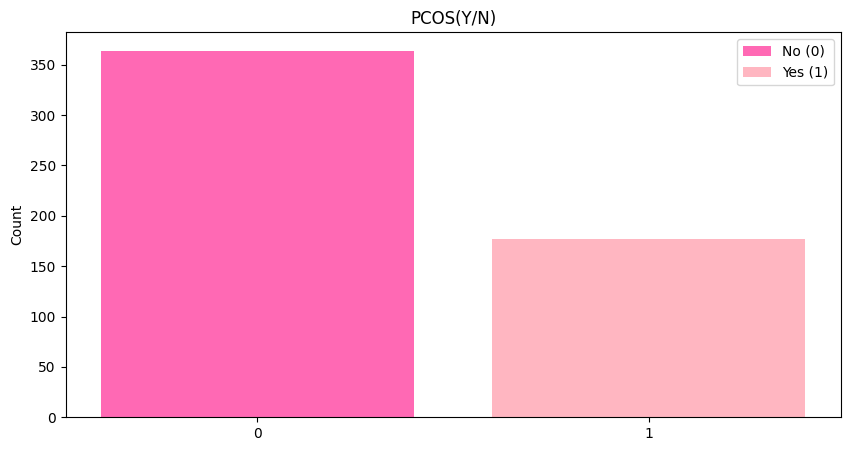

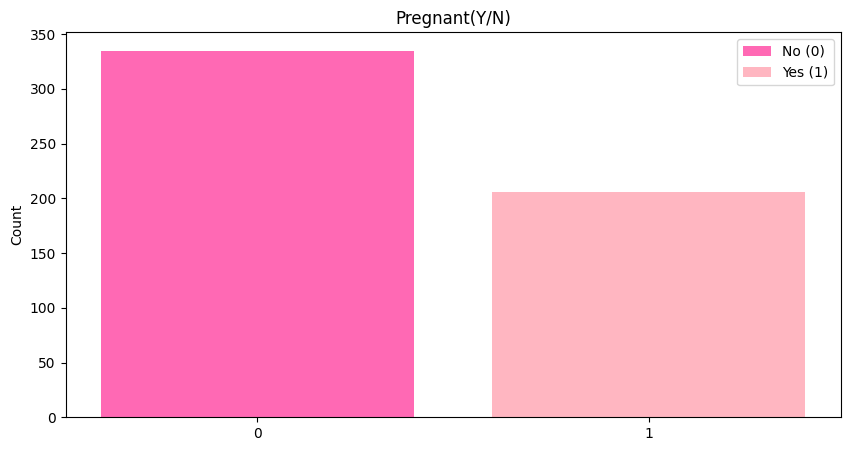

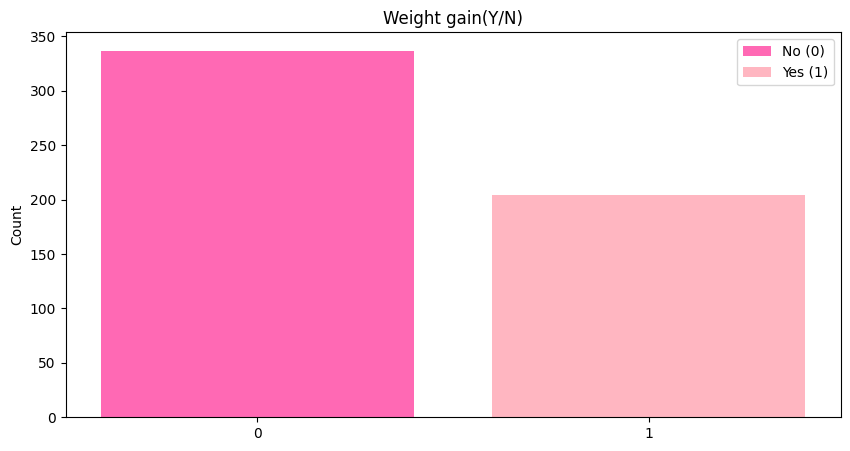

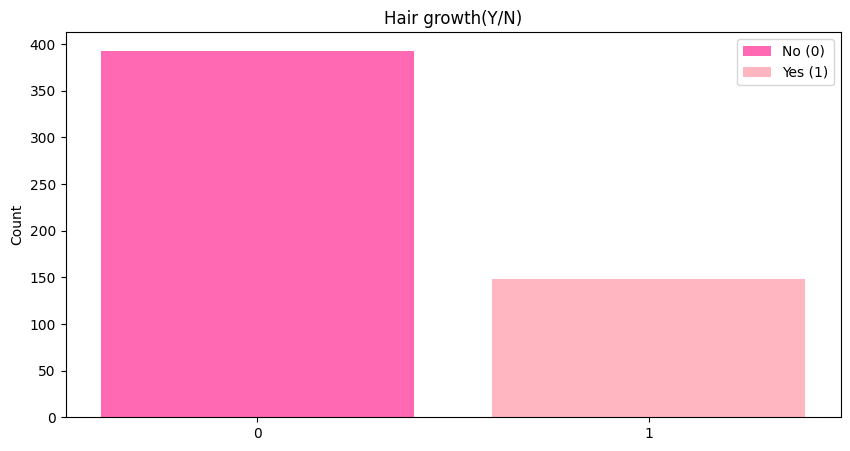

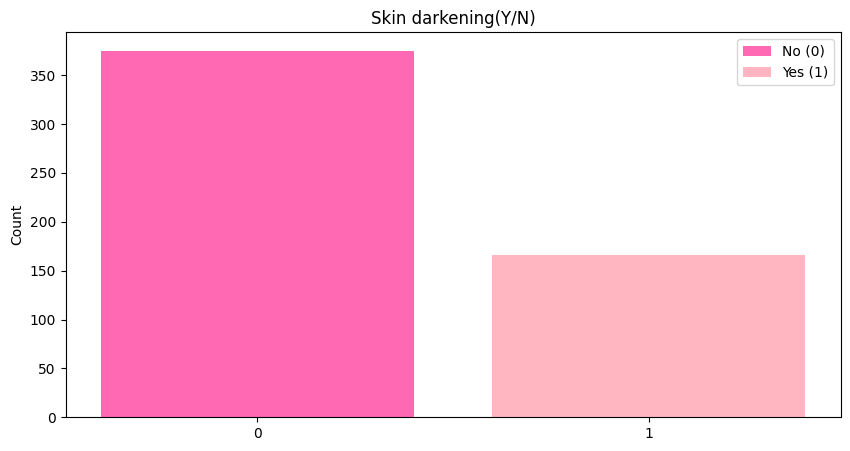

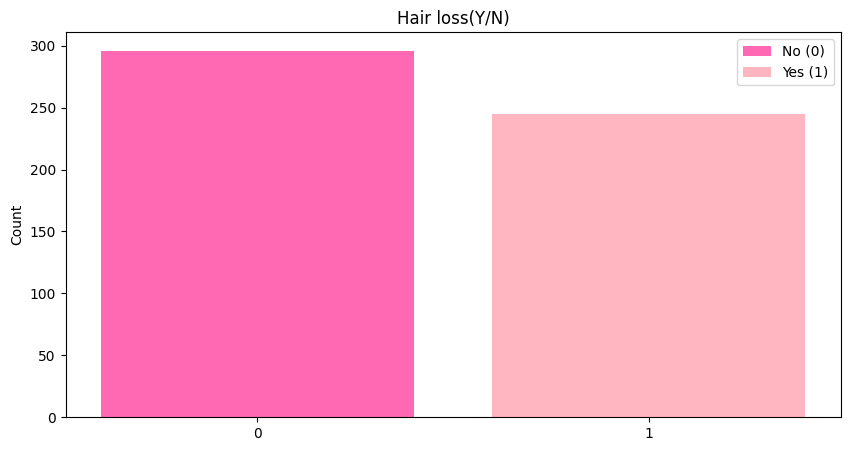

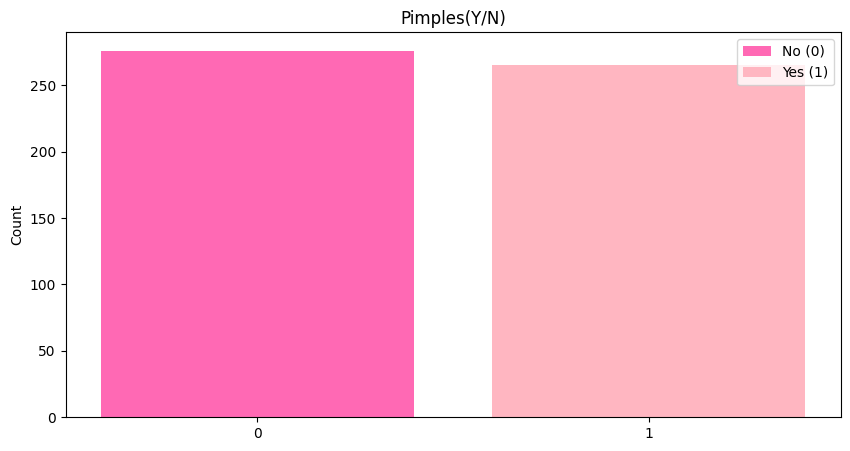

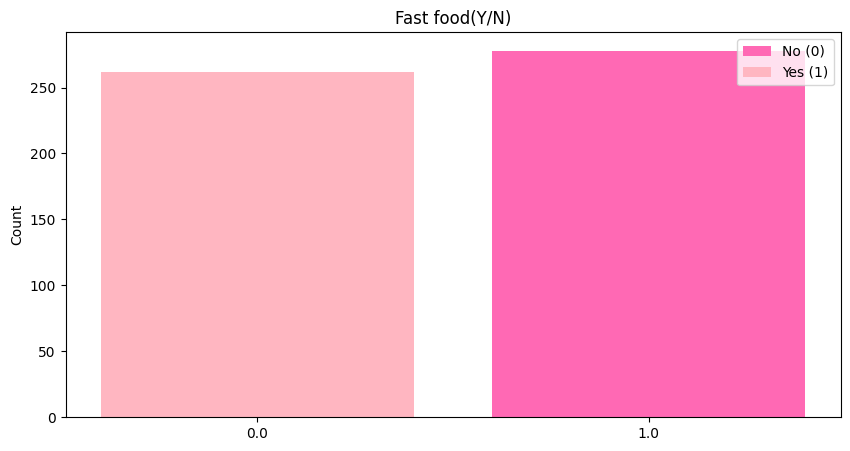

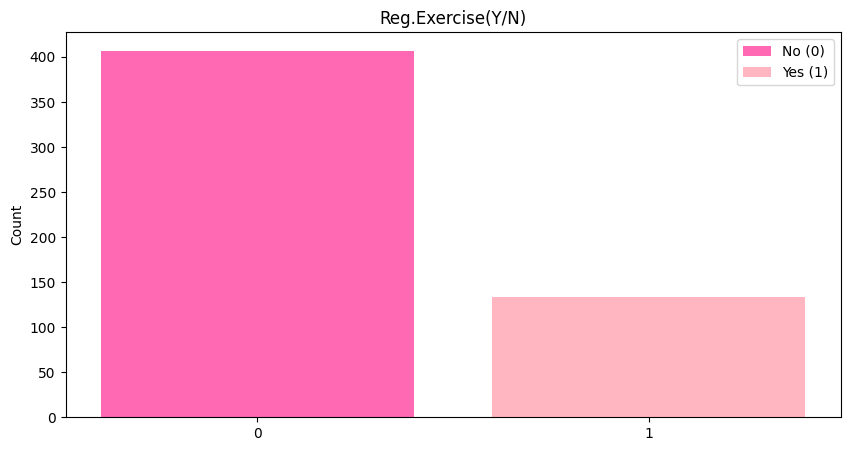

In [3]:
columns = ["PCOS(Y/N)", "Pregnant(Y/N)", "Weight gain(Y/N)", "Hair growth(Y/N)", "Skin darkening(Y/N)", "Hair loss(Y/N)", 
                "Pimples(Y/N)", "Fast food(Y/N)", "Reg.Exercise(Y/N)"]
    
for column in columns:
    bar_plot(df,column)


Analizirali smo i numeričke podatke kao što su starost, težina, visina, dužina ciklusa i krvna grupa pomoću histograma. Svaka od ovih kategorija je vizualizovana kako bi se prikazala raspodela podataka. Takođe, analizirali smo BMI kategorije, grupišući podatke u četiri kategorije: nedovoljna težina, zdrava težina, prekomerna težina i gojaznost. 

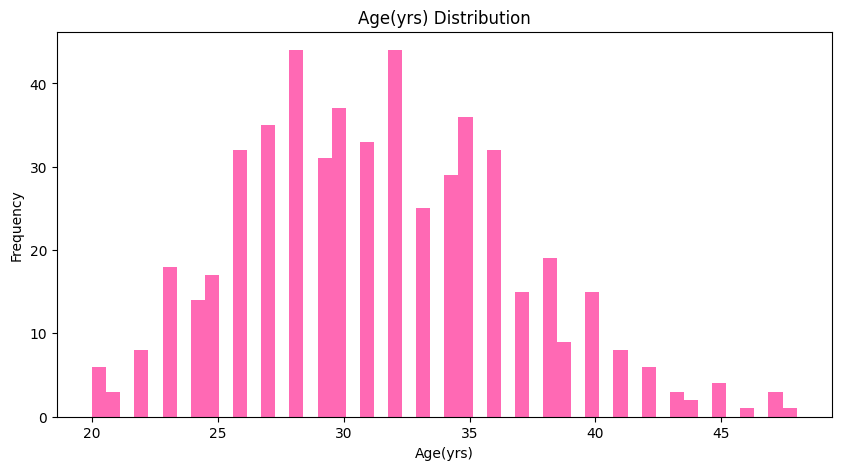

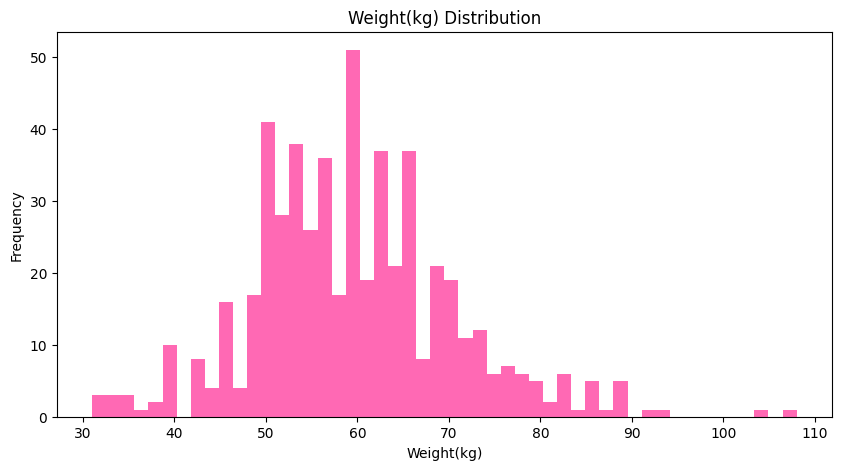

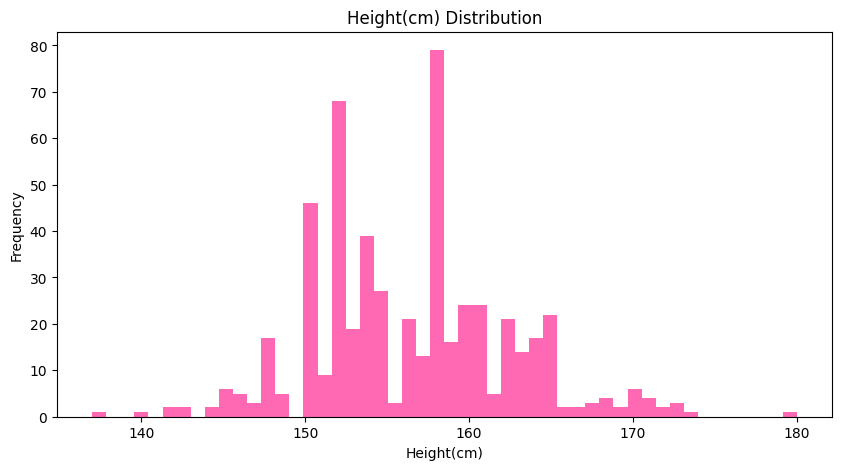

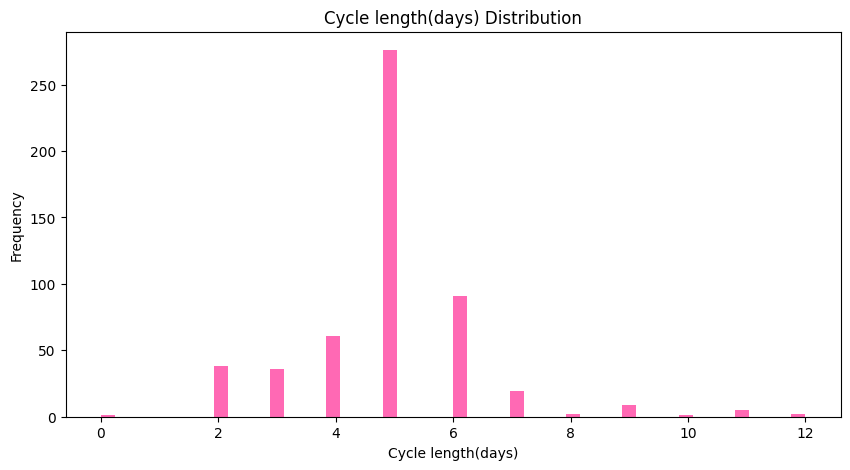

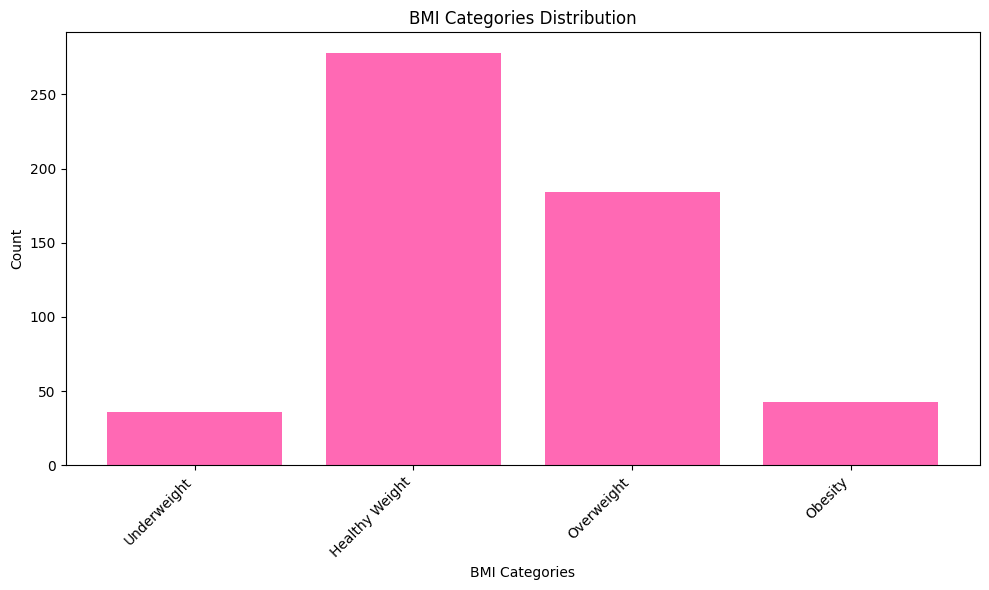

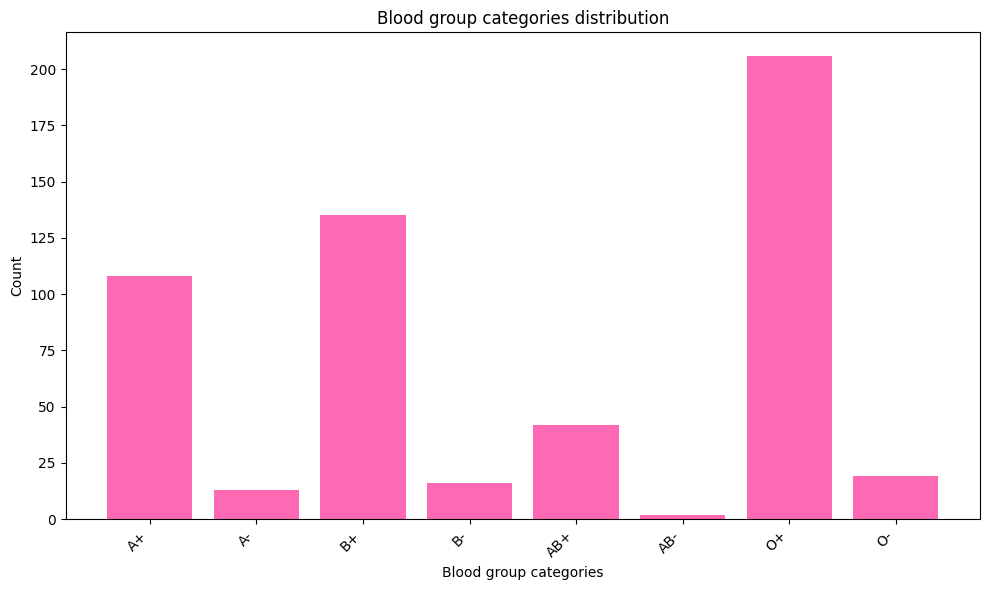

In [4]:
columns = ["Age(yrs)", "Weight(kg)", "Height(cm)", "Cycle length(days)"]
for column in columns:
    plot_histogram(df,column)

bmi_histogram(df)
blood_group_histogram(df)

# Pretprocesiranje podataka

## Obrada nedostajućih vrednosti 

Proveravamo da li imamo nedostajuće vrednosti u našem setu podataka. Ako postoji onda vršimo obradu tih nedostajućih vrednosti korišćenjem metoda kao što su
popunjavanje srednjom vrednošću ili različiti tipovi interpolacije.

In [5]:
print(check_for_missing_values(df))

                      N missing  % missing
Age(yrs)                     11   2.033272
Pulse rate(bpm)              12   2.218115
Marraige Status(Yrs)          1   0.184843
AMH(ng/mL)                   21   3.881701
Vit D3(ng/mL)                37   6.839187
Fast food(Y/N)                1   0.184843


Po rezultatima vidimo da postoje nedostajuće vrednosti u kolonama za Age (yrs), Pulse rate(bpm), Marraige Status (Yrs), AMH(ng/mL), Vit D3 (ng/mL), Fast food (Y/N). Vršimo popunjavanje nedostajućih vrednosti.

In [4]:
df["Age(yrs)"] = df["Age(yrs)"].interpolate(method="linear", limit_direction="both")
df["Pulse rate(bpm)"] = df["Pulse rate(bpm)"].interpolate(method="spline", order=4, limit_direction="both")
df["Marraige Status(Yrs)"] = df["Marraige Status(Yrs)"].interpolate(method="spline", order=4, limit_direction="both")
df["AMH(ng/mL)"] = df["AMH(ng/mL)"].interpolate(method="spline", order=4, limit_direction="both")
df["Vit D3(ng/mL)"] = df["Vit D3(ng/mL)"].interpolate(method="spline", order=4, limit_direction="both")
df["Fast food(Y/N)"] = df["Fast food(Y/N)"].fillna(df['Fast food(Y/N)'].median())

## Analiza korelacije između faktora 

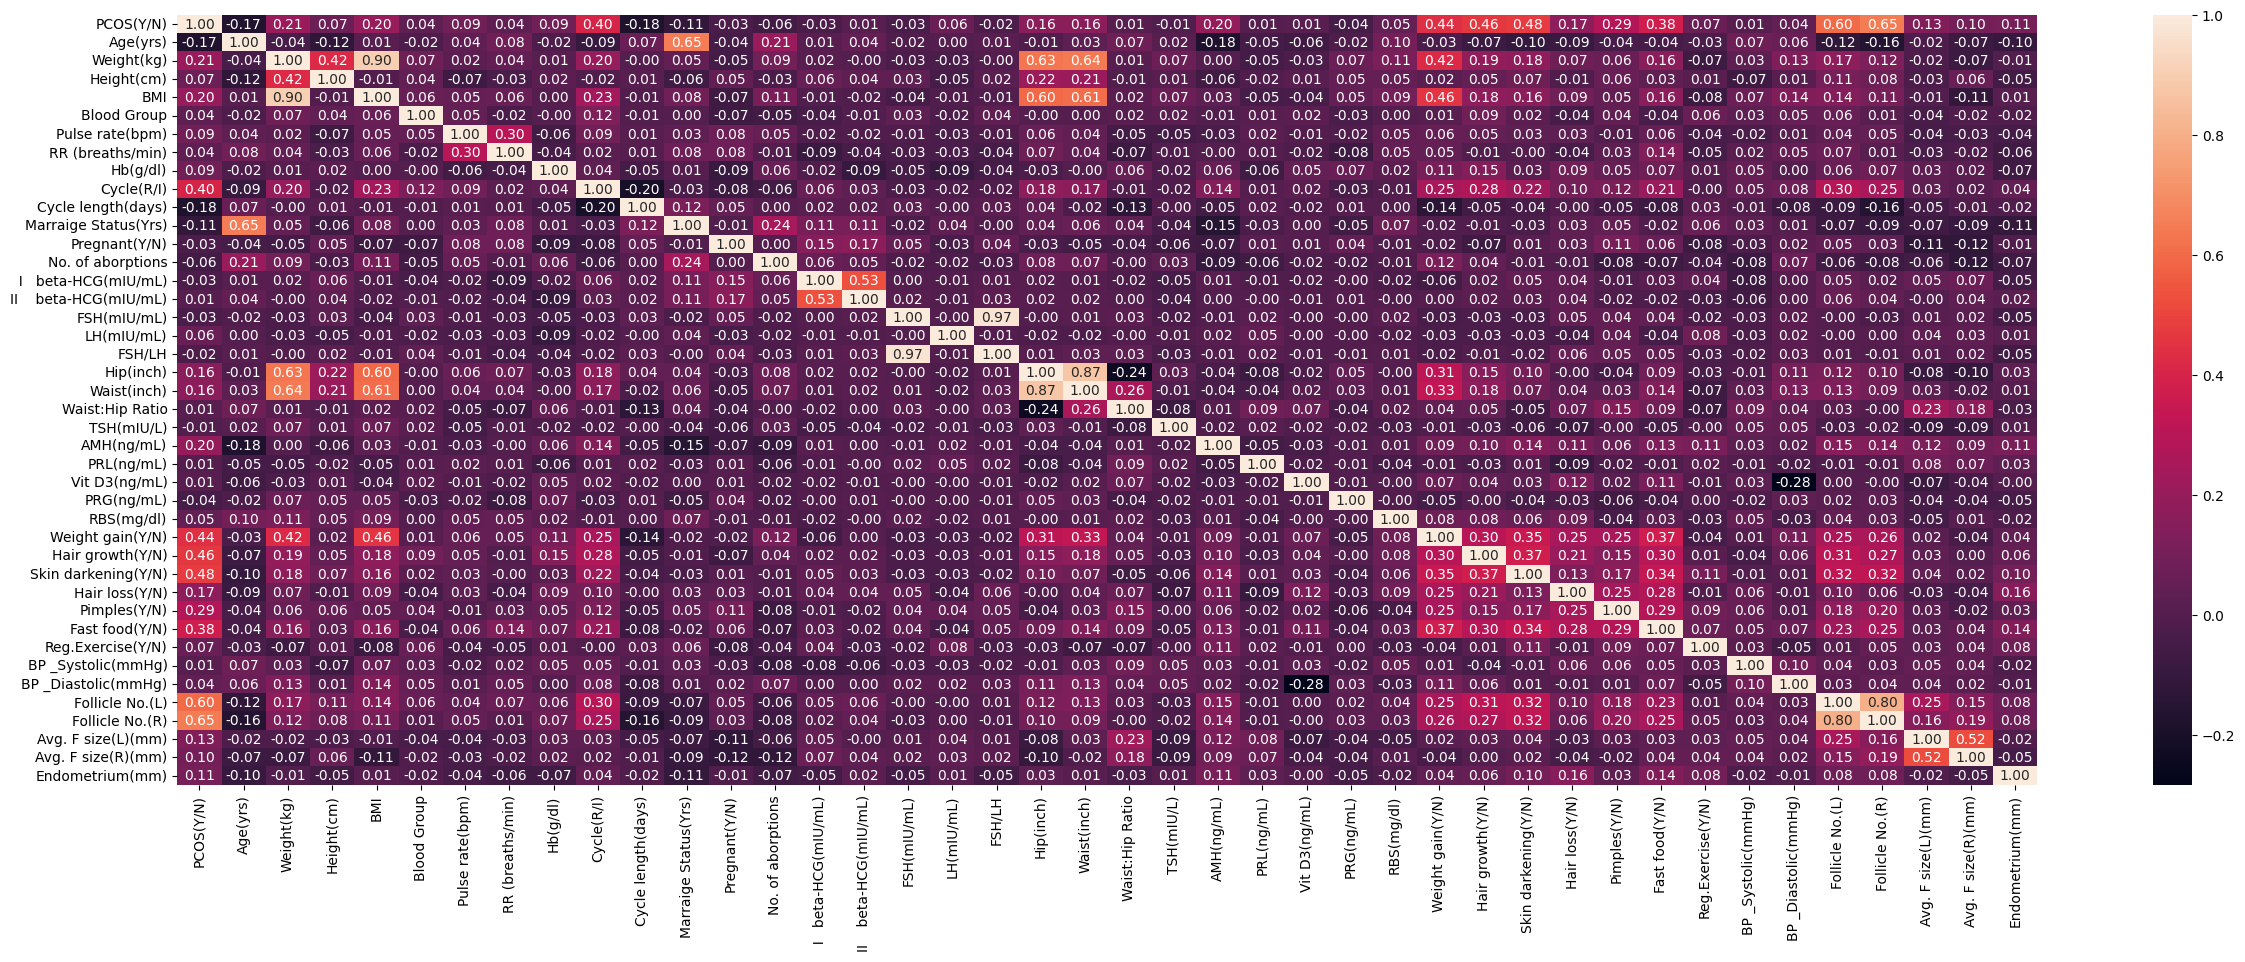

In [7]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=["Sl. No", "Patient File No."])
correlation_matrix(df_copy)

Korelaciona matrica prikazuje odnose između različitih varijabli u datasetu.
Glavni ciljevi analize matrice su:
1. Identifikacija varijabli koje su u visokoj korelaciji.
2. Pronalaženje značajnih odnosa koji mogu ukazivati na uzročno-posledične veze ili faktore rizika PCOS-a.

PCOS pokazuje jake obrasce povezanosti sa fizičkim i hormonskim simptomima što se vidi i u matrici korelacije.

*Korelacija sa PCOS (Y/N) kolonom*:
- Weight gain (Y/N): ~0.44 – Povećanje telesne težine je čest simptom PCOS-a.
- Hair growth (Y/N): ~0.46 – Hirzutizam (prekomerni rast dlaka) je još jedan uobičajen simptom PCOS-a.
- Skin darkening (Y/N): ~0.48 – Ukazuje na povezanost PCOS-a sa hiperpigmentacijom kože (npr. acanthosis nigricans).
- Pimples (Y/N): ~0.29 – Akne su takođe povezane sa hormonskim disbalansima.
- Fast food (Y/N): ~0.38 – Može ukazivati na potencijalne životne navike povezane s PCOS-om.
- Cycle (R/N): ~ 0.40 -  Žene sa nepravilnim ciklusima su češće dijagnostikovane sa PCOS-om.
- Follicle No: ~ 0.60 - Klinički, povećan broj folikula (12 ili više u svakom jajniku) je jedan od ultrazvučnih kriterijuma za dijagnozu PCOS-a

*Ostali odnosi:*
- Visoko korelisana sa Hair growth(Y/N) i Skin darkening(Y/N): ~0.37 – Simptomi se često pojavljuju zajedno.
- Follicle No.(L) i Follicle No.(R) imaju vrlo visoku pozitivnu korelaciju (~0.87). Ovo ima smisla jer se broj folikula u levom i desnom jajniku obično ima slično.
- PRL (ng/mL): Ima slabe korelacije sa većinom varijabli (~0.05 do 0.10), što ukazuje na manju povezanost sa PCOS-om i srodnim simptomima.
- FSH/LH: Povezani su negativno sa PCOS-om i nekim simptomima poput Weight gain (Y/N) (~-0.18). Hormonalni disbalans je glavni faktor kod PCOS-a.

Iz ove matrice zaključujemo da možemo da izbacimo  kolone poput Blood Group, RBS (mg/dl), BP_Systolic (mmHg), i BP_Diastolic (mmHg) jer imaju vrlo nisku korelaciju sa ciljem analize i ostalim varijablama, te ne doprinose značajno modelu.
Takođe, kolone sa visokom međusobnom korelacijom, poput Follicle No. (L) i Follicle No. (R) ili Hair growth(Y/N) i Skin darkening(Y/N) mogu se redukovati zadržavanjem samo jedne za smanjenje redundantnosti.

# Razvoj regresionih modela

In [ ]:
Y = df["PCOS(Y/N)"]
X = df[["Cycle(R/I)", "AMH(ng/mL)", "PRG(ng/mL)", "Fast food(Y/N)", "BMI", "Cycle length(days)",
        "Weight gain(Y/N)", "Hair growth(Y/N)", "Skin darkening(Y/N)", 
        "Pimples(Y/N)", "Follicle No.(L)"]]
 

x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=60)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=60)
    
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)
    
linear_model = get_linear_model(x_train, y_train)
ridge_model = get_ridge_model(x_train_scaled, y_train)
lasso_model = get_lasso_model(x_train_scaled, y_train)
logistic_model = get_logistic_model(x_train, y_train)

Za ovaj projekat smo odabrali karakteristike koje smatramo važnim za analizu PCOS-a, bazirano na prethodnim istraživanjima i korelaciji između varijabli. Odabrane karakteristike su:

- **Cycle (R/I)**: Da li je ciklus regulisan ili neregulisan.
- **AMH (ng/mL)**: Anti-milerov hormon.
- **PRG (ng/mL)**: Progesteron.
- **Fast food (Y/N)**: Konzumacija brze hrane.
- **BMI**: Indeks telesne mase.
- **Cycle length (days)**: Dužina menstrualnog ciklusa.
- **Weight gain (Y/N)**: Da li je došlo do dobitka na težini.
- **Hair growth (Y/N)**: Da li postoji rast dlaka.
- **Skin darkening (Y/N)**: Da li je došlo do potamnjivanja kože.
- **Pimples (Y/N)**: Da li postoje akne.
- **Follicle No. (L)**: Broj folikula na levom jajniku.

Ove karakteristike su izabrane jer se prethodna istraživanja poklapaju sa njihovim značajem u vezi sa PCOS-om.

**Podela podataka:** Podaci su podeljeni u tri grupe:  
- **Trening skup (60%)**: Koristi se za obučavanje modela.  
- **Validacioni skup (20%)**: Koristi se za proveru tačnosti modela tokom obučavanja.  
- **Test skup (20%)**: Koristi se za testiranje konačnog modela.

Podaci su podeljeni koristeći metodu `train_test_split`, sa zadatim nasumičnim semenom (random_state=60) kako bi podela bila ponovljiva.

**Skaliranje podataka:** Da bi podaci bili ujednačeni, primenili smo standardizaciju pomoću `StandardScaler`-a. Ovo je važno za modele poput **Ridge** i **Lasso regresije**, koji su osetljivi na razliku u opsegu podataka. Skaliranje nije bilo potrebno za **Linearnu** i **Logističku regresiju**, jer ovi modeli nisu osetljivi na razlike u opsegu.

**Izbor modela:** Koristili smo nekoliko regresionih modela:
1. **Linearna regresija**: Koristi se kao osnovni model za početnu procenu.
2. **Ridge regresija**: Koristi L2 regularizaciju da bi smanjila varijansu i sprečila prekomerno prilagođavanje.
3. **Lasso regresija**: Koristi L1 regularizaciju, koja može ukloniti nepotrebne karakteristike i učiniti model lakšim za interpretaciju.
4. **Logistička regresija**: Koristi se jer je cilj klasifikacija, odnosno predviđanje prisustva ili odsustva PCOS-a.

Svaki model je izabran sa ciljem da pomogne u boljoj analizi i predviđanju rezultata.

# Evaluacija modela

Za svaki model, pozvali smo funkciju koja prikazuje rezultate evaluacije, odnosno kako se model ponaša na validacionim podacima.

In [9]:
print("Evaluation Results (Validation Set):")
evaluate_model(linear_model, "Linear Regression", x_val, y_val)
evaluate_model(ridge_model, "Ridge Regression", x_val_scaled, y_val)
evaluate_model(lasso_model, "Lasso Regression", x_val_scaled, y_val)
evaluate_model(logistic_model, "Logistic Regression", x_val, y_val)

Evaluation Results (Validation Set):
Linear Regression Model:
SSE: 12.047983745922553
RMSE: 0.3339991093623431
R²: 0.5410291906315219
R² adj : 0.48843878539138375

Ridge Regression Model:
SSE: 12.046490098447482
RMSE: 0.33397840496898124
R²: 0.5410860914877149
R² adj : 0.48850220613734885

Lasso Regression Model:
SSE: 11.95914782124001
RMSE: 0.3327654582384818
R²: 0.5444134163337139
R² adj : 0.4922107869552853

Logistic Regression Model:
SSE: 16
RMSE: 0.3849001794597505
R²: 0.3904761904761904
R² adj : 0.3206349206349205



Linear Regression: Ima SSE od 12.05, što znači da model nije savršeno precizan, ali je u okvire prihvatljive greške. RMSE je 0.334, što je okej, ali ne idealno. R² je 0.541, što znači da model objašnjava 54.1% varijacije u podacima, što je pristojno, ali nije sjajno. Adjusted R² je 0.488, što ukazuje na to da model nije idealan, ali nije ni loš.

Ridge Regression: Ima skoro identičan SSE i RMSE kao Linear Regression, što znači da nije mnogo bolji. R² je vrlo sličan Linear Regression (0.541), a adjusted R² je 0.488, što ponovo pokazuje da model nije značajno bolji od Linear Regression.

Lasso Regression: Ovaj model ima nešto bolji SSE (11.96) i RMSE (0.333), što ga čini preciznijim od prethodna dva modela. R² je 0.544, što je malo bolje od Linear i Ridge Regression, i adjusted R² je 0.492, što ukazuje da je ovaj model malo bolji u objašnjavanju podataka.

Logistic Regression: Ovaj model ima mnogo veći SSE (16) i RMSE (0.385), što znači da je najmanje precizan po ovim metrikama. R² je 0.390, što znači da objašnjava samo 39% varijacije, što je prilično loše za regresiju. Adjusted R² je 0.320, što još više potvrđuje da ovaj model nije dobar u ovom kontekstu. Međutim, treba napomenuti da su metrike kao što su SSE, RMSE i R² neprikladni za Logistic Regression, jer je to klasifikacioni model. Ovi metrike su specifični za regresiju, pa bi za Logistic Regression trebalo koristiti druge metrike.

Takođe, pozvali smo funkciju koja prikazuje rezultate evaluacije, odnosno kako se model ponaša na test podacima.

In [10]:
print("Final Evaluation Results (Test Set):")
evaluate_model(linear_model, "Linear Regression", x_test, y_test)
evaluate_model(ridge_model, "Ridge Regression", x_test_scaled, y_test)
evaluate_model(lasso_model, "Lasso Regression", x_test_scaled, y_test)
evaluate_model(logistic_model, "Logistic Regression", x_test, y_test)

Final Evaluation Results (Test Set):
Linear Regression Model:
SSE: 8.907997682795754
RMSE: 0.2858754088470138
R²: 0.5903072795676215
R² adj : 0.5438472803433312

Ridge Regression Model:
SSE: 8.90697720860855
RMSE: 0.2858590338522483
R²: 0.5903542127686363
R² adj : 0.5438995358661105

Lasso Regression Model:
SSE: 8.87684524258198
RMSE: 0.28537509908828973
R²: 0.5917400289276642
R² adj : 0.5454425064349251

Logistic Regression Model:
SSE: 13
RMSE: 0.34534917843520574
R²: 0.4021097046413503
R² adj : 0.3343077123841839



Linear Regression: SSE  iznosi 8.91, što znači da je zbir grešaka u predikcijama relativno nizak. RMSE je 0.29, što ukazuje da je prosečna greška u predikcijama 0.29. R² (Coefficient of Determination) je 0.59, što znači da model objašnjava 59% varijacije u podacima, što nije loše, ali može biti bolje. R² adjusted je 0.54, što je malo niže, jer uzima u obzir broj varijabli i pokazuje da model ne donosi značajnu promenu u odnosu na jednostavniji model.

Ridge Regression: SSE je vrlo sličan onom za linearnu regresiju i iznosi 8.91. RMSE je takođe 0.29, što znači da su greške u predikcijama vrlo slične onima iz linearnog modela. R² iznosi 0.59, što znači da Ridge regresija ne donosi veliko poboljšanje u objašnjenju podataka u poređenju sa običnom linearnom regresijom. Prilagođeni R² je 0.54, što je takođe veoma slično prethodnoj vrednosti, što ukazuje da Ridge regresija ne donosi značajnu prednost u odnosu na običnu linearnu regresiju.

Lasso Regression: SSE je 8.88, što je blago niže nego za prethodne modele, što znači da su greške u predikcijama nešto manja. RMSE je 0.29, što je skoro isto kao kod drugih modela, ukazujući da je prosečna greška još uvek slična. R² je 0.59, što znači da model objašnjava oko 59% varijacije, kao i ostali modeli, pa se može reći da nije doneta velika promena u objašnjenju podataka. R² adjusted je 0.55, što je malo veće nego kod prethodnih modela, što može značiti da Lasso koristi varijable malo efikasnije, ali je razlika minimalna.

Logistic Regression: SSE je 13, što je znatno veće od prethodnih modela, što znači da su greške u predikcijama veće. RMSE je 0.35, što je takođe veće u odnosu na druge modele, što ukazuje da su greške u predikcijama prosečno veće. R² je 0.40, što znači da model objašnjava samo 40% varijacije u podacima, što je znatno niže u poređenju sa prethodnim modelima. R² adjusted je 0.33, što je još niže, što sugeriše da model nije efikasan u objašnjenju podataka. Međutim, treba napomenuti da ove metrike nisu odgovarajuće za logističku regresiju, jer je to model za klasifikaciju, a ne za regresiju, pa se za evaluaciju ovakvih modela koriste druge metrike poput tačnosti ili AUC.

AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) je merilo koje se koristi za evaluaciju performansi logističkog regresionog modela, jer pokazuje koliko dobro model razlikuje pozitivne od negativnih primera. AUC vrednost se kreće između 0 i 1, pri čemu viša vrednost označava bolju sposobnost modela da pravilno klasifikuje podatke. Ova metrika je korisna jer je nezavisna od praga klasifikacije i daje preciznu sliku o modelu, čak i kada su klase neravnotežno raspodeljene. Zbog toga je AUC-ROC pogodna za ocenu modela u različitim situacijama i idealna za logističke modele.

In [11]:
y_pred_logistic_proba_val = logistic_model.predict_proba(x_val)[:, 1] 
auc_val = roc_auc_score(y_val, y_pred_logistic_proba_val)
print(f"Logistic Regression AUC-ROC on Validation Set: {auc_val:.4f}\n")

Logistic Regression AUC-ROC on Validation Set: 0.9189



AUC-ROC vrednost od 0.9189 za logistički regresioni model na validacionom skupu podataka ukazuje na vrlo dobru sposobnost modela da razlikuje pozitivne od negativnih primera.

# Izbor modela

In [7]:
linear_r2_train = linear_model.rsquared
linear_r2_test = linear_model.rsquared 
ridge_score_train = ridge_model.score(x_train_scaled, y_train)
ridge_score_test = ridge_model.score(x_test_scaled, y_test)
lasso_score_train = lasso_model.score(x_train_scaled, y_train)
lasso_score_test = lasso_model.score(x_test_scaled, y_test)
logistic_score_train = logistic_model.score(x_train, y_train) * 100
logistic_score_test = logistic_model.score(x_test, y_test) * 100

print(f"Linear Regression R² on Train: {linear_r2_train:.4f}")
print(f"Linear Regression R² on Test: {linear_r2_test:.4f}")
print(f"Ridge Regression R² on Train: {ridge_score_train:.4f}")
print(f"Ridge Regression R² on Test: {ridge_score_test:.4f}")
print(f"Lasso Regression R² on Train: {lasso_score_train:.4f}")
print(f"Lasso Regression R² on Test: {lasso_score_test:.4f}")
print(f"Logistic Regression Accuracy on Train: {logistic_score_train:.2f}%")
print(f"Logistic Regression Accuracy on Test: {logistic_score_test:.2f}%")

Linear Regression R² on Train: 0.5656
Linear Regression R² on Test: 0.5656
Ridge Regression R² on Train: 0.5656
Ridge Regression R² on Test: 0.5904
Lasso Regression R² on Train: 0.5633
Lasso Regression R² on Test: 0.5917
Logistic Regression Accuracy on Train: 89.81%
Logistic Regression Accuracy on Test: 88.07%


Logistički regresioni model se često bira u problemima poput predviđanja ili dijagnostikovanja bolesti, kao što je sindrom policističnih jajnika (PCOS), jer je idealan za klasifikacione zadatke. U slučaju PCOS-a, cilj može biti predviđanje verovatnoće da neka žena ima ovaj sindrom na osnovu različitih faktora, kao što su hormonski nivoi, simptomi ili genetika. Iako linearni modeli poput linearnog, Ridge i Lasso regresije mogu biti korisni za analizu povezanosti između faktora i nekih kontinuiranih parametara, logistički regresioni model je specifično dizajniran da precizno proceni verovatnoću prisustva bolesti, jer daje izlaz između 0 i 1, što je ključno za ovakve klasifikacione probleme. Sa tačnošću od oko 89% na trening i 88% na test skupu, logistički regresioni model pokazuje da je efikasan u generalizaciji, što ga čini prikladnim za korišćenje u dijagnostici i predviđanju PCOS-a.

## Validacija pretpostavki modela

In [ ]:
result_linear = check_model_assumptions(linear_model, x_train, y_train)
print(result_linear)

result_ridge = check_model_assumptions(ridge_model, x_train, y_train)
print(result_ridge)

result_lasso = check_model_assumptions(lasso_model, x_train, y_train)
print(result_lasso)

result_logistic = check_model_assumptions(logistic_model, x_train, y_train)
print(result_logistic)

Normality of errors assumption is not satisfied. Distribution type: non-normal
Independence of errors (no autocorrelation) assumption is not satisfied.
Independence of errors (no autocorrelation) assumption is not satisfied.
Perfect collinearity assumption is not satisfied.


Pri proveri pretpostavki modela, za linearni model smo uočili da pretpostavka normalnosti grešaka nije zadovoljena, jer distribucija grešaka nije normalna. Ovo može ukazivati na problem sa specifičnostima podataka koje linearni model ne može efikasno obraditi. Za Ridge i Lasso modele, pretpostavka nezavisnosti grešaka (bez autokorelacije) nije zadovoljena, što znači da postoji međusobna zavisnost grešaka između različitih opažanja, što može uticati na preciznost modela. Za logistički regresioni model, pretpostavka o savršenoj kolinearnosti nije zadovoljena, što znači da postoji visoka korelacija među nezavisnim promenljivama, što može dovesti do problema u proceni koeficijenata modela. Kako bismo rešili ovaj problem, koristićemo Varijansni Inflacioni Faktor (VIF) da bismo identifikovali i procenili potencijalnu multikolinearnost među prediktorima, što će nam pomoći u daljoj optimizaciji modela.

In [14]:
vif_result = calculate_vif(x_train)
print(vif_result)

               Variable        VIF
0                 const  72.438423
1            Cycle(R/I)   1.187949
2            AMH(ng/mL)   1.033782
3            PRG(ng/mL)   1.025159
4        Fast food(Y/N)   1.363750
5                   BMI   1.380189
6    Cycle length(days)   1.085562
7      Weight gain(Y/N)   1.746252
8      Hair growth(Y/N)   1.389572
9   Skin darkening(Y/N)   1.431063
10         Pimples(Y/N)   1.157583
11      Follicle No.(L)   1.206005


Iz rezultata koji su dobijeni iz VIF analize, možemo primetiti da postoji ozbiljan problem sa savršenom kolinearnosti zbog visoke vrednosti VIF-a za konstantu (const), koja ima vrednost 72.44. Ovo je uobičajeno, jer konstanta u modelu može biti visoko korelisana sa drugim varijablama, ali je obično zanemarena kada analiziramo multikolinearnost.

S druge strane, sve ostale varijable, uključujući Cycle(R/I), AMH(ng/mL), PRG(ng/mL), BMI, Weight gain(Y/N), i druge, imaju VIF vrednosti koje su mnogo niže od 10, što znači da ne pokazuju ozbiljan problem sa multikolinearnošću. Varijable sa VIF vrednostima ispod 10 obično ne izazivaju zabrinutost u smislu visoke korelacije sa drugim prediktorima i mogu se smatrati stabilnim za upotrebu u modelu.

Na osnovu svih analiza koje smo sproveli, i uzimajući u obzir rezultate VIF-a, AUC-ROC, i tačnosti modela, odlučili smo da za dalji rad izaberemo **logistički regresioni model**. Iako su neki od drugih modela, poput linearnih i Ridge/Lasso regresija, pokazali zadovoljavajuće rezultate, logistički regresioni model je najbolji za ovaj zadatak jer je specifično dizajniran za klasifikaciju, pokazuje visoku tačnost na test skupu (oko 88%) i ima dobar kapacitet za generalizaciju. Pored toga, iako je identifikovana potencijalna problematika sa multikolinearnošću u odnosu na konstantu, varijable sa VIF vrednostima ispod 10 nisu izazvale ozbiljne probleme. Stoga, logistički regresioni model predstavlja najpogodniji izbor za dalji rad u ovom kontekstu.

# Vizualizacija podataka i logistic modela

In [ ]:
pcos_visualization(df, logistic_model, x_test, y_test)

## Vizualizacija podataka

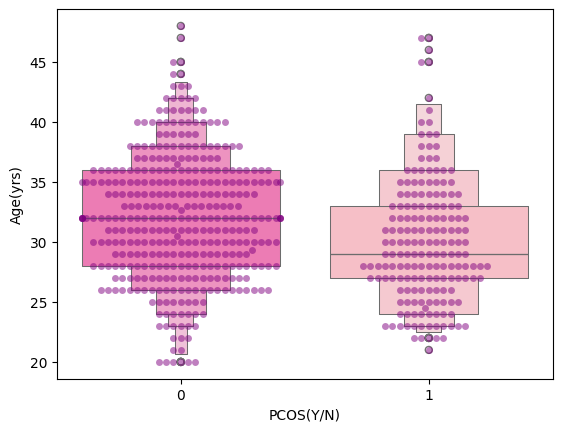

Na osnovu grafa, može se zaključiti da žene sa PCOS-om (1) imaju uži raspon godina i češće su koncentrisane u reproduktivnom dobu (25-35 godina), dok žene bez PCOS-a (0) imaju širi raspon godina i ravnomerniju distribuciju.

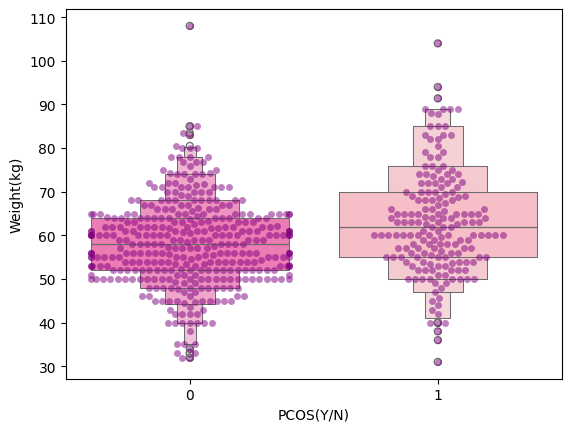

Na osnovu grafika, može se zaključiti da žene sa PCOS-om (1) imaju veći raspon težine i više slučajeva ekstremno visokih težina u poređenju sa ženama bez PCOS-a (0). Kod žena bez PCOS-a, težine su ravnomernije raspoređene, dok žene sa PCOS-om pokazuju sklonost ka višim težinama.

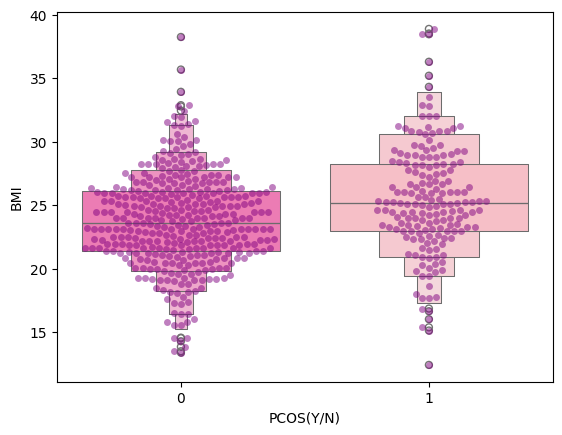

Na osnovu grafika koji prikazuje BMI u odnosu na PCOS status (0 - bez PCOS-a, 1 - sa PCOS-om), može se zaključiti:

- Osobe sa PCOS-om (1) imaju tendenciju ka višem BMI u poređenju sa osobama bez PCOS-a (0).  
- Raspon BMI vrednosti je širi kod osoba sa PCOS-om, sa većim brojem slučajeva povišenih BMI vrednosti (gojaznost).  
- Kod osoba bez PCOS-a, BMI je generalno niži i uže raspoređen.  
- Postoji nekoliko ekstremnih vrednosti (outliers) sa visokim BMI u obe grupe, ali su izraženije kod osoba sa PCOS-om.  

Ovaj obrazac potvrđuje povezanost PCOS-a sa povećanom telesnom težinom i gojaznošću, što je u skladu sa poznatim simptomima PCOS-a.

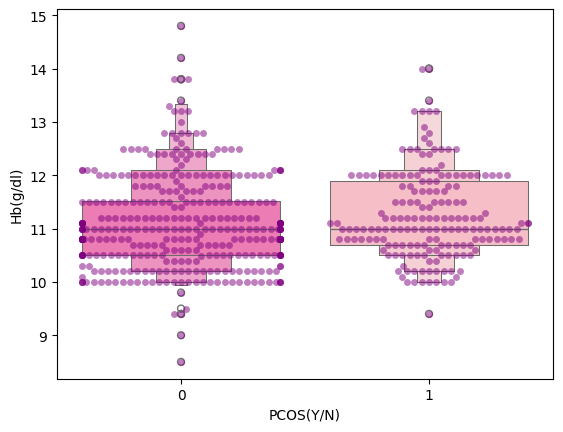

Grafik pokazuje da nivo hemoglobina (Hb) nema značajnu razliku između osoba sa PCOS-om i bez njega, pri čemu obe grupe imaju slične medijane i opsege vrednosti, uz nekoliko outliera u obe kategorije.

<!-- Grafik pokazuje da nivo hemoglobina (Hb) nema značajnu razliku između osoba sa PCOS-om i bez njega, pri čemu obe grupe imaju slične medijane i opsege vrednosti, uz nekoliko outliera u obe kategorije. -->

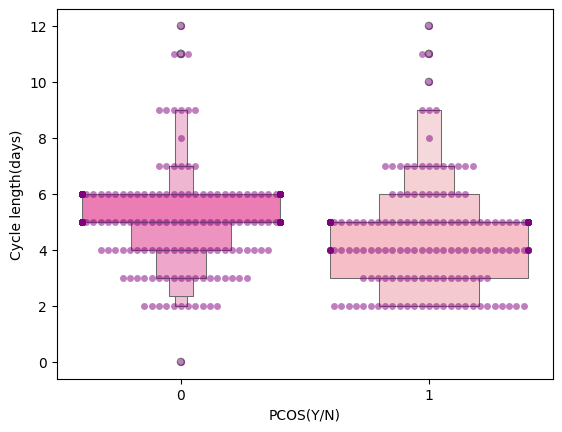

Grafikon pokazuje da dužina ciklusa (Cycle length) ima blago povećan opseg kod osoba sa PCOS-om (1) u poređenju sa onima bez PCOS-a (0)
- Kod osoba bez PCOS-a (0): vrednosti su uglavnom između 2 i 8 dana, sa nekoliko outliera koji dosežu ispod 2 i iznad 10 dana.
- Kod osoba sa PCOS-om (1): opseg je nešto širi, uglavnom između 2 i 9 dana, sa outlierima iznad 10 dana.

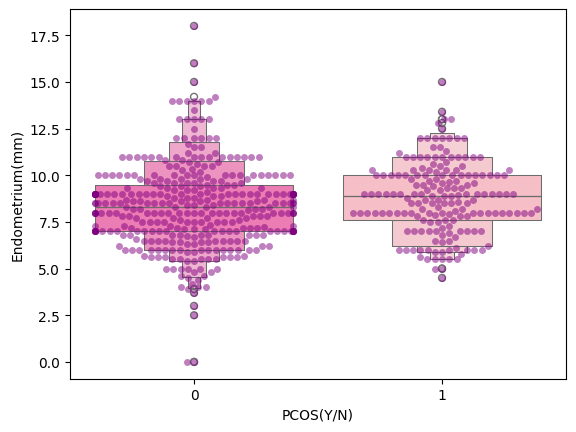

Grafikon pokazuje da debljina endometrijuma (Endometrium) ima slične medijane i raspone za obe grupe, uz prisustvo outliera.
- Kod osoba bez PCOS-a (0): vrednosti su uglavnom između 6 i 12 mm, uz nekoliko outliera ispod 5 mm i iznad 15 mm.
- Kod osoba sa PCOS-om (1): opseg je sličan, između 6 i 13 mm, sa outlierima ispod 5 mm i iznad 17 mm.

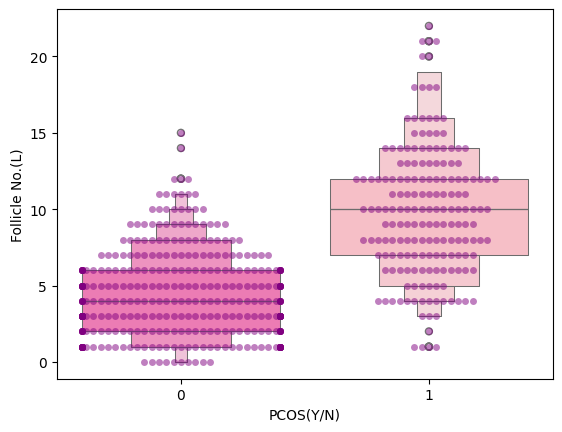

Grafikon prikazuje broj folikula u levom jajniku. Kod osoba bez PCOS-a (0), broj folikula se najčešće kreće između 2 i 8, sa nekoliko outliera iznad 10. Kod osoba sa PCOS-om (1), broj folikula je značajno veći, najčešće između 5 i 15, uz outliere koji dosežu i preko 20 folikula. Ovo ukazuje na povećanu folikularnost kod osoba sa PCOS-om.

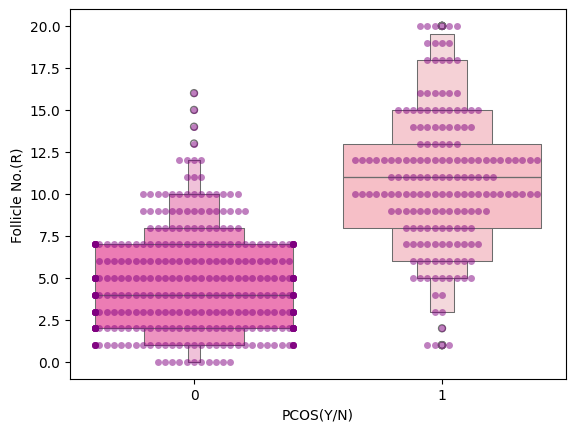

Sličan obrazac je prisutan i u desnom jajniku. Kod osoba bez PCOS-a (0), broj folikula se uglavnom nalazi između 2 i 8, sa malim brojem vrednosti iznad tog opsega. Kod osoba sa PCOS-om (1), opseg broja folikula je širi, sa dominantnim rasponom između 5 i 15, dok outlieri dostižu vrednosti preko 20 folikula. Oba grafikona jasno pokazuju da PCOS utiče na povećanje broja folikula u oba jajnika.

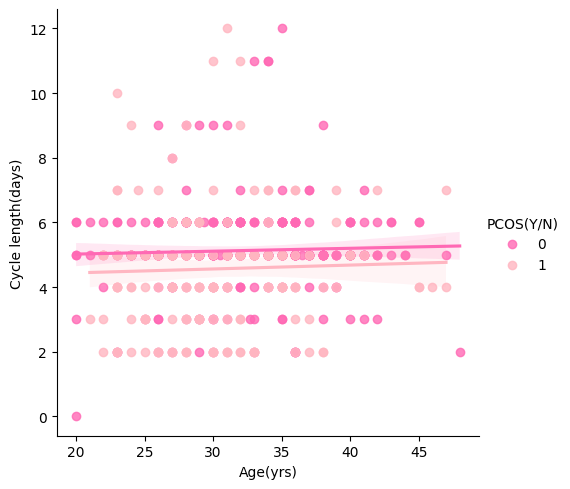

Ova slika prikazuje odnos između godina starosti (Age (yrs)) i dužine menstrualnog ciklusa (Cycle length (days)) kod ispitanica, uz podelu na prisustvo PCOS-a (Polycystic Ovary Syndrome). Svetlije tačke označavaju pozitivne slučajeve (PCOS = 1), dok tamnije predstavljaju negativne (PCOS = 0).
Većina ispitanica ima dužinu ciklusa između 4 i 6 dana, bez obzira na starost ili prisustvo PCOS-a. Linije trenda ukazuju na vrlo blag porast dužine ciklusa sa starošću u obe grupe, ali bez značajnih razlika između ispitanica sa i bez PCOS-a.
Zaključak je da dužina menstrualnog ciklusa nema značajnu povezanost sa prisustvom PCOS-a, iako se u proseku blago povećava sa godinama starosti.

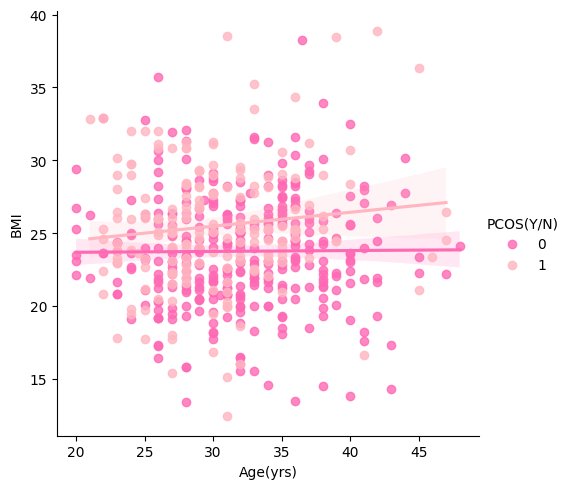

Ova slika prikazuje odnos između godina starosti (Age (yrs)) i indeksa telesne mase (BMI) kod ispitanica, uz podelu na prisustvo PCOS-a (Polycystic Ovary Syndrome). Svetlije tačke predstavljaju pozitivne slučajeve (PCOS = 1), dok tamnije označavaju negativne (PCOS = 0).
Većina ispitanica ima BMI između 20 i 30, nezavisno od starosti ili prisustva PCOS-a. Linije trenda za obe grupe ukazuju na vrlo blag porast BMI-a sa godinama, ali bez značajnih razlika između grupa.
Zaključak je da BMI ne pokazuje jasnu povezanost sa prisustvom PCOS-a, iako starije ispitanice blago teže ka višem BMI-ju.

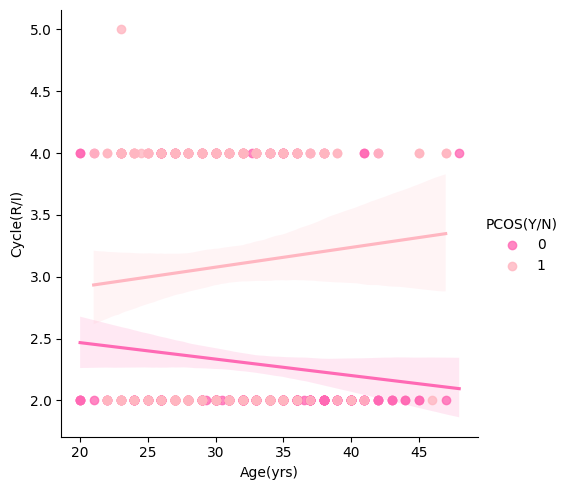

Ova slika prikazuje odnos između godina starosti (*Age (yrs)*) i rezultata cikličnog hormonskog odnosa (*Cycle (R/I)*) kod ispitanica, uz podelu na prisustvo PCOS-a (*Polycystic Ovary Syndrome*). Svetlije tačke predstavljaju ispitanice sa PCOS-om (*PCOS = 1*), dok tamnije označavaju one bez PCOS-a (*PCOS = 0*).
Vidljive su dve grupe vrednosti za *Cycle (R/I)*, koje pokazuju različite obrasce. Kod ispitanica sa PCOS-om (*PCOS = 1*), linija trenda pokazuje blagi porast *Cycle (R/I)* sa godinama starosti. S druge strane, kod ispitanica bez PCOS-a (*PCOS = 0*), primećuje se blagi pad ovog parametra sa starošću.
Zaključak je da se *Cycle (R/I)* razlikuje između grupa sa i bez PCOS-a i pokazuje suprotne trendove u zavisnosti od prisustva sindroma. Ovo može ukazivati na povezanost ovog parametra sa starenjem i statusom PCOS-a.

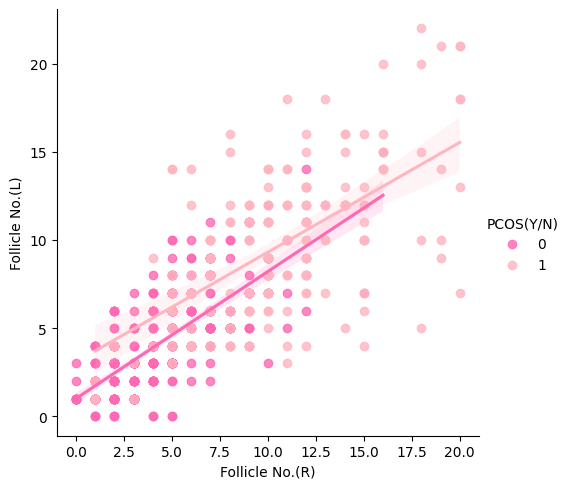

Ova slika prikazuje odnos između broja folikula u levom (Follicle No. (L)) i desnom jajniku (Follicle No. (R)) kod ispitanica, uz podelu na prisustvo PCOS-a (Polycystic Ovary Syndrome). Svetlije tačke označavaju pozitivne slučajeve (PCOS = 1), dok tamnije predstavljaju negativne (PCOS = 0). 
Vidljivo je da postoji pozitivna korelacija između broja folikula u levom i desnom jajniku – kako broj folikula raste u jednom jajniku, raste i u drugom. Osobe sa PCOS-om generalno imaju više folikula u oba jajnika. Ovo ukazuje na povezanost većeg broja folikula sa prisustvom PCOS-a.

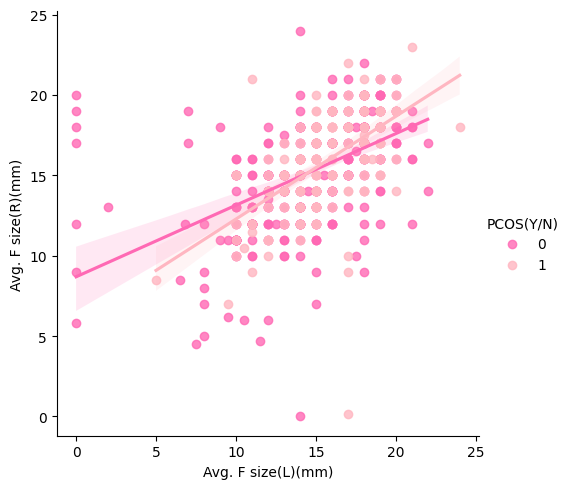

Ova slika prikazuje odnos između prosečne veličine folikula u levom (Avg. F size (L)) i desnom jajniku (Avg. F size (R)) kod istih ispitanica. Ponovo postoji pozitivna korelacija – veći folikuli u jednom jajniku često prate veće folikule u drugom. Svetlije tačke (PCOS = 1) se nalaze u višim vrednostima prosečnih veličina, što sugeriše da osobe sa PCOS-om obično imaju veće folikule u poređenju sa osobama bez PCOS-a. 

## Vizalizacija logistic modela

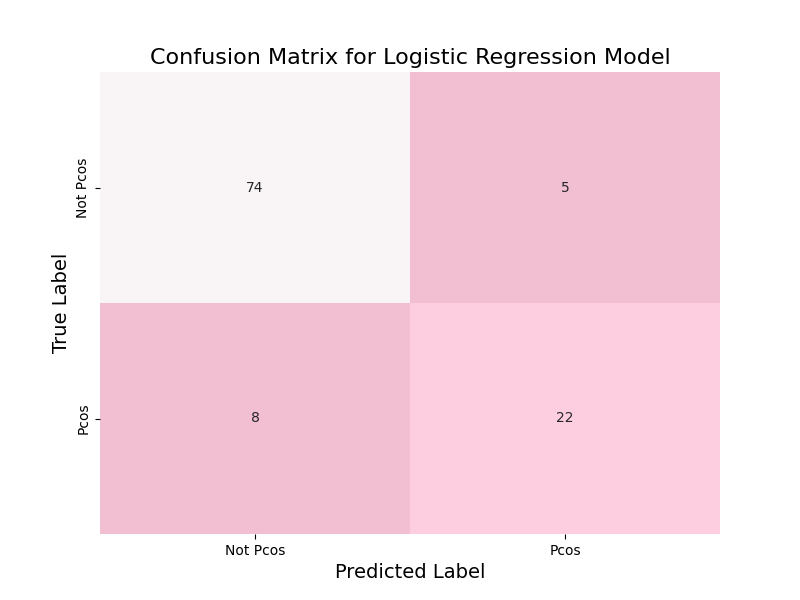

Ova tabela pokazuje kako model za prepoznavanje (logistička regresija) procenjuje da li neko ima PCOS (policistični jajnici) ili ne, tako što poredi svoje predikcije sa stvarnim rezultatima.
Gornji levi broj (74) prikazuje koliko puta je model tačno rekao da osoba nema PCOS, dok donji desni (22) pokazuje koliko puta je tačno rekao da osoba ima PCOS. 
Preostala dva broja (5 i 8) predstavljaju greške modela – gde je pogrešno rekao da osoba ima ili nema PCOS. Na osnovu ove raspodele možemo proceniti koliko je model pouzdan i koliko često greši, što nam pomaže da odlučimo koliko je koristan u praksi.

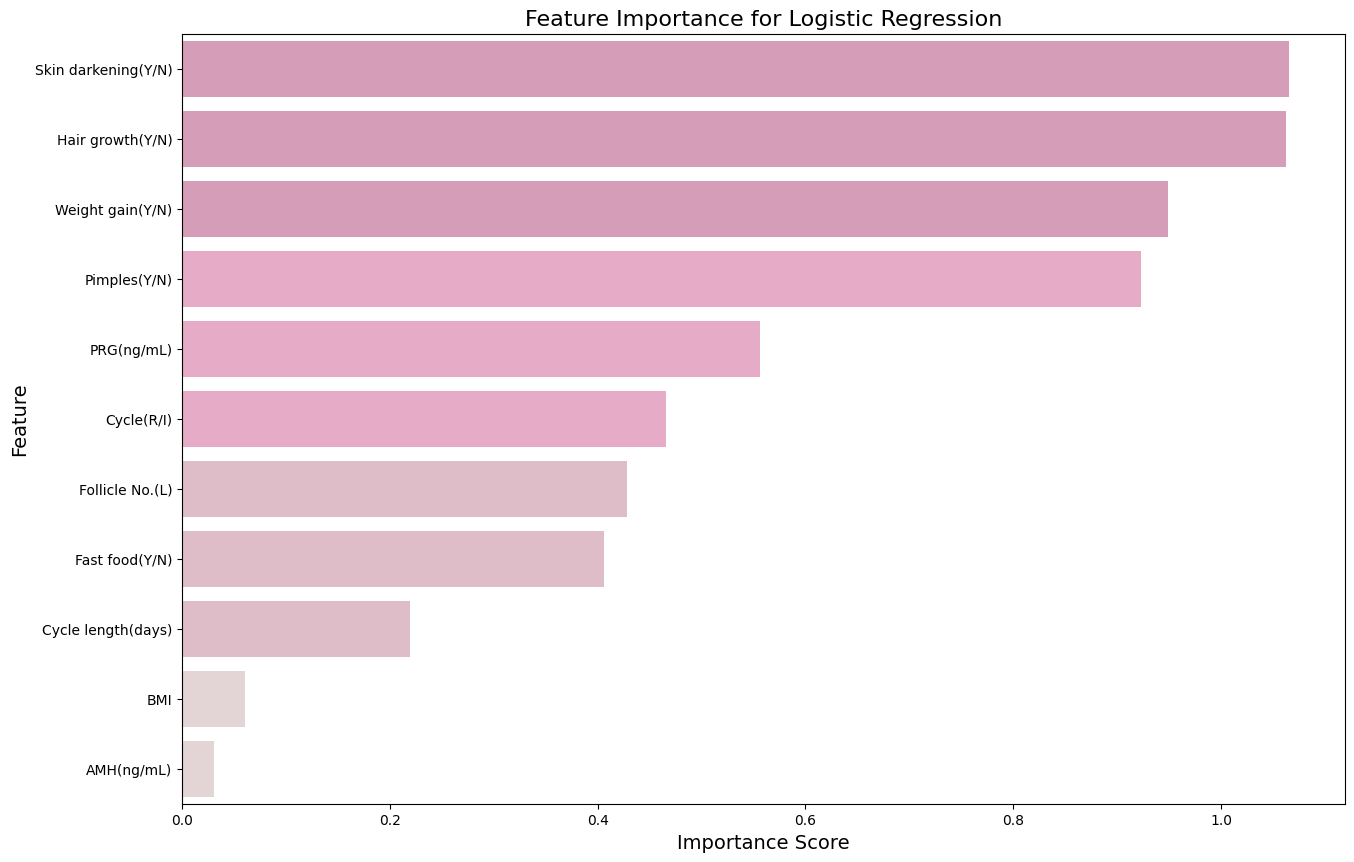

Ova tabela prikazuje značaj različitih faktora (osobina) za predikciju PCOS-a u modelu logističke regresije. Najvažniji faktori su Skin darkening, Hair growth, Weight gain i Pimples, što znači da oni najviše doprinose odluci modela. Ostali faktori, poput nivoa hormona (PRG i AMH), dužine ciklusa ili BMI, imaju manji uticaj na predikciju. Što je faktor viši na listi, to je značajniji za odluke modela.

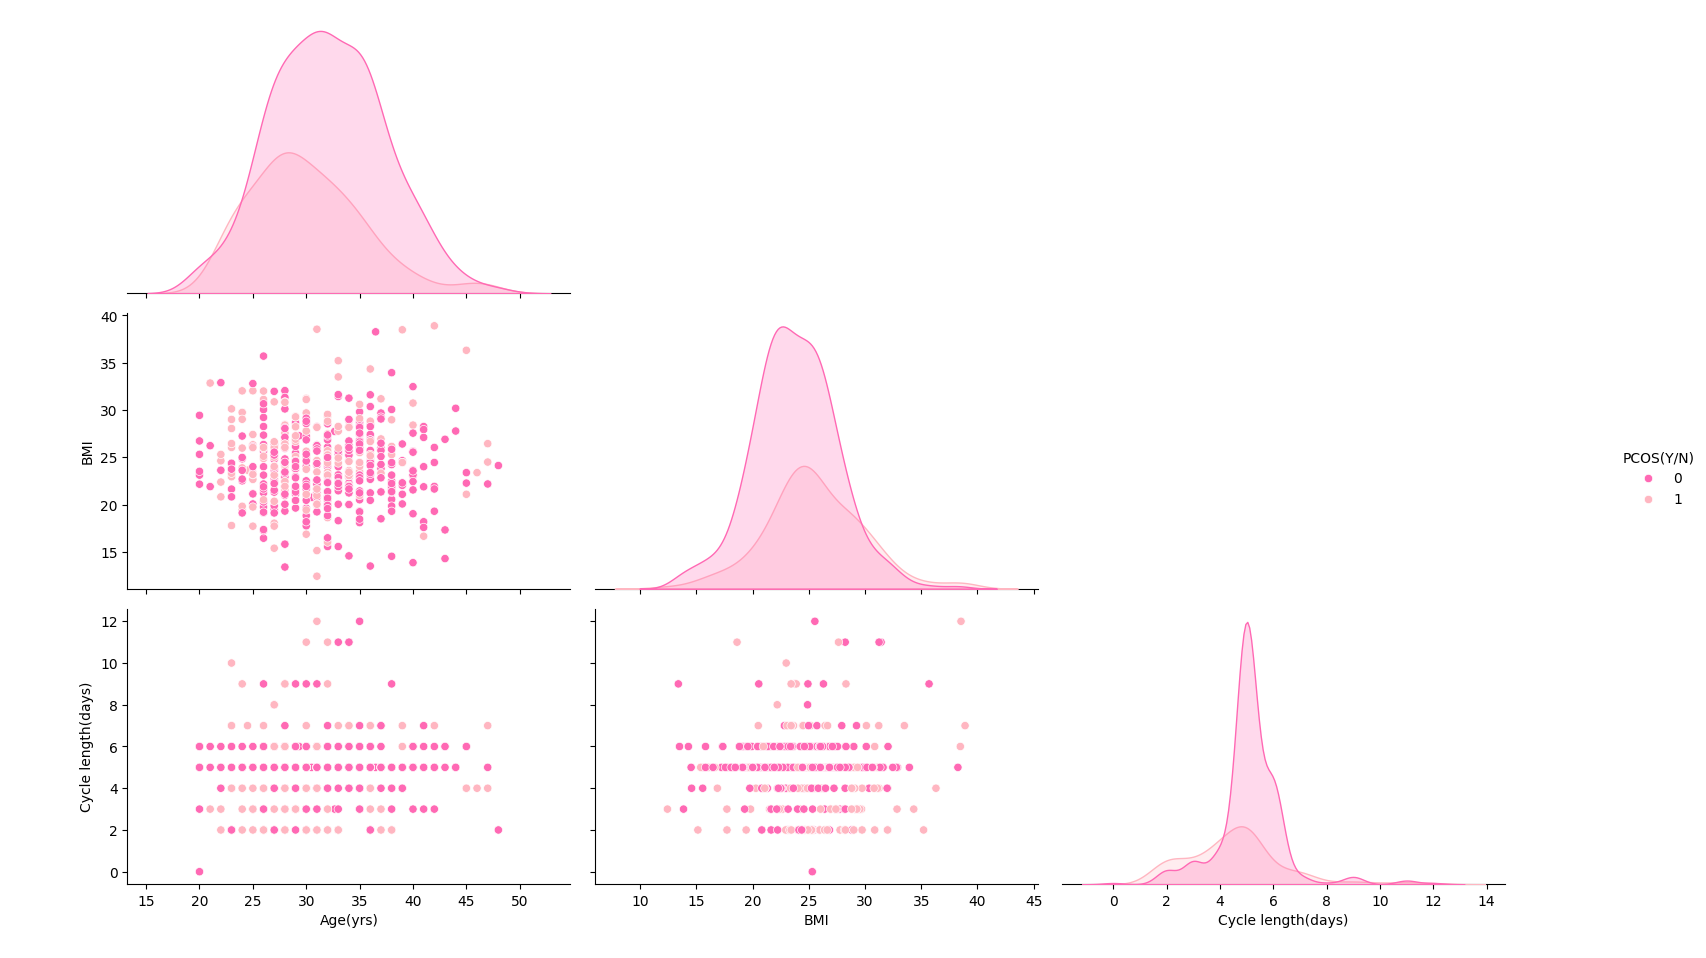

Ova slika predstavlja višedimenzionalnu analizu nekoliko ključnih parametara povezanih s PCOS-om (Sindromom policističnih jajnika): starost, BMI (indeks telesne mase) i dužinu menstrualnog ciklusa (u danima). Fokus je na poređenju između osoba sa PCOS-om (označeno tamnijom ružičastom bojom) i osoba bez PCOS-a (svetlija ružičasta boja). Na osnovu distribucija i odnosa između ovih parametara, mogu se uočiti značajne karakteristike povezane s PCOS-om.

### Distribucije (dijagonalni grafikoni):
- **BMI (indeks telesne mase):** Vidljiva je razlika u distribuciji između dve grupe. Osobe sa PCOS-om imaju tendenciju ka višim vrednostima BMI-ja, što može ukazivati na povezanost PCOS-a sa gojaznošću. Ipak, postoji značajan preklop sa zdravom populacijom, što znači da ne pate sve osobe sa PCOS-om od prekomerne težine.
- **Dužina menstrualnog ciklusa:** Ovde je razlika još izraženija. Osobe sa PCOS-om često imaju kraće ili neredovne menstrualne cikluse, dok su ciklusi kod zdravih osoba uglavnom stabilniji i koncentrisani oko određenih vrednosti.
- **Starost:** Distribucija starosti pokazuje da većina uzorka pripada mlađoj populaciji (između 20 i 30 godina), ali nije primećena značajna razlika između dve grupe.

### Scatter plotovi (odnosi između parametara):
1. **BMI i starost:** Nema jasne korelacije između BMI-ja i starosti, ali većina podataka se odnosi na osobe u reproduktivnom dobu (20-30 godina). Kod osoba sa PCOS-om postoji blagi trend viših BMI vrednosti u poređenju sa zdravom populacijom.
2. **Dužina ciklusa i starost:** Kod osoba sa PCOS-om ciklusi su često kraći i neredovni bez obzira na starost. Ovo ukazuje na hormonalne disbalanse koji nisu povezani sa godinama već su direktan simptom sindroma.
3. **Dužina ciklusa i BMI:** Jasnije se vidi veza između višeg BMI-ja i kraćih ili neredovnih ciklusa kod osoba sa PCOS-om. Ovo može ukazivati na povezanost PCOS-a sa insulinskom rezistencijom i gojaznošću, koji su česti pratioci ovog sindroma.

Osobe sa PCOS-om imaju tendenciju ka višem BMI-ju i kraćim, neredovnim menstrualnim ciklusima, što su ključni simptomi ovog sindroma. Međutim, postoji značajno preklapanje sa zdravom populacijom, posebno kod BMI-ja, što ukazuje na potrebu za dodatnim parametrima prilikom dijagnostikovanja. Podaci takođe ističu važnost kombinacije fizioloških i hormonskih indikatora u identifikaciji PCOS-a, kao i potrebu za ranim intervencijama koje uključuju regulaciju telesne mase i upravljanje menstrualnim ciklusom. 

Ovaj grafikon pomaže da se bolje razume kako različiti faktori međusobno utiču i omogućava lekarima i istraživačima da prepoznaju obrasce koji su ključni za dijagnozu i tretman PCOS-a.

<!-- 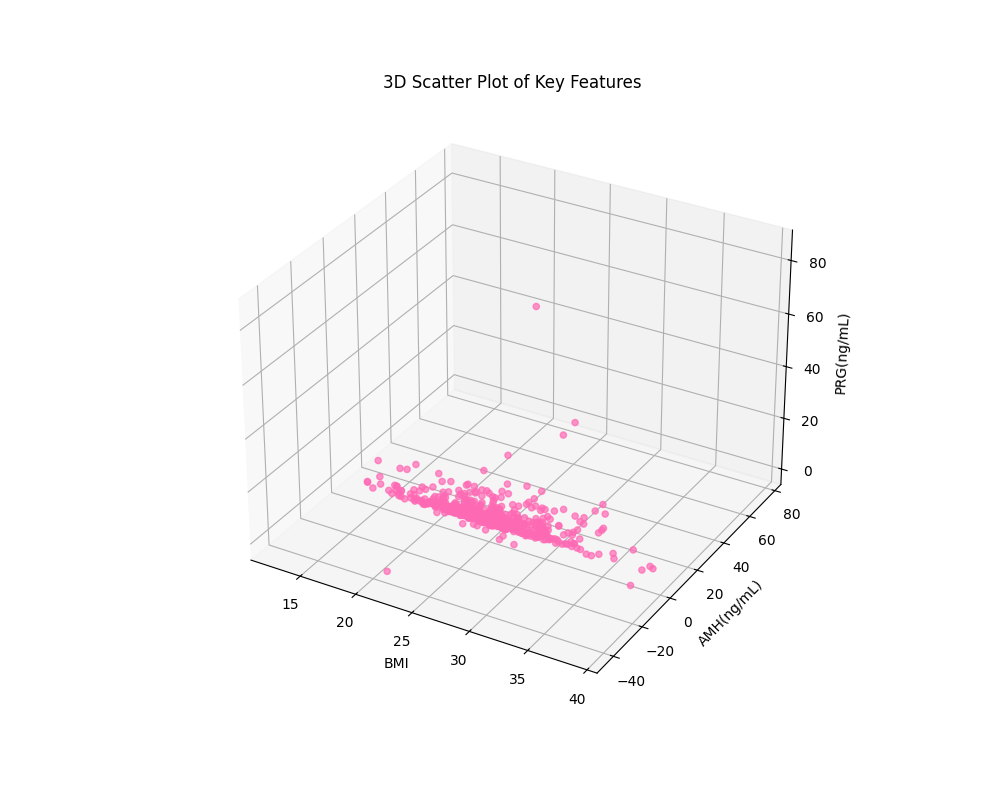 -->

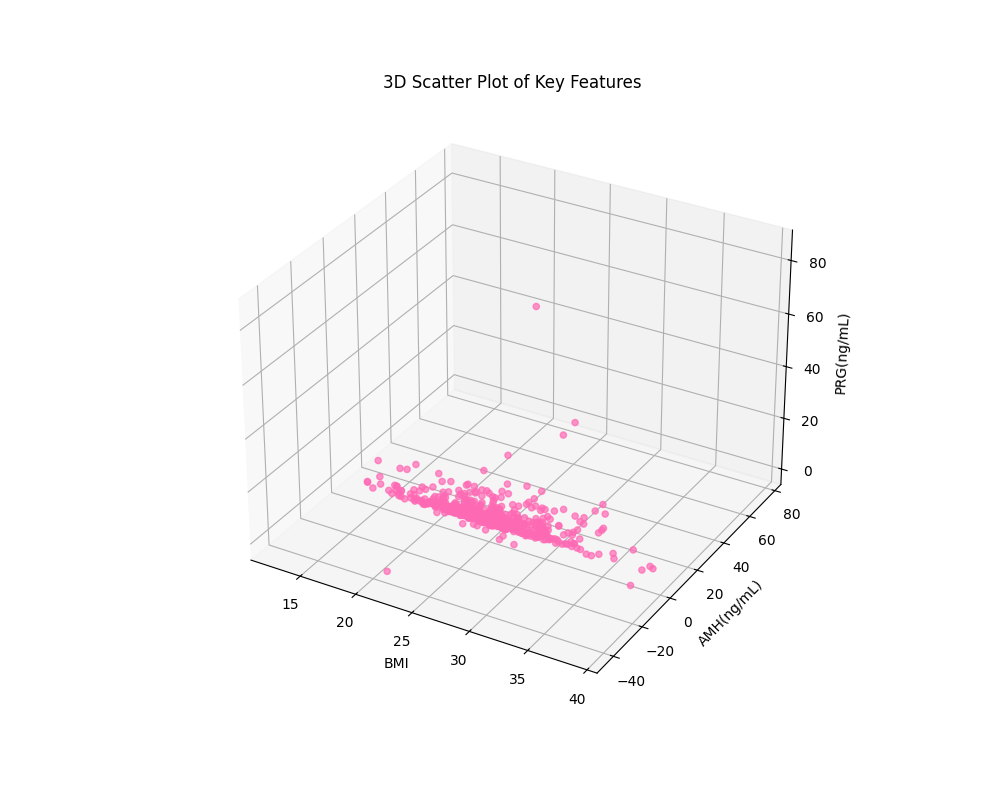

Ovaj 3D scatter plot prikazuje međusobnu povezanost između tri ključne karakteristike koje su važne u analizi PCOS-a: BMI (indeks telesne mase), AMH (Anti-Müllerov hormon, izražen u ng/mL) i PRG (progesteron, izražen u ng/mL). Vizualizacija omogućava analizu kako se ovi parametri ponašaju u odnosu jedni na druge i kako mogu doprineti identifikaciji PCOS-a.

### Osnovna analiza:
1. **BMI (os X):** Kao što je uobičajeno, BMI pokazuje širinu vrednosti između 15 i 40. Većina podataka je grupisana u srednjem opsegu BMI-ja (20-30), što ukazuje da većina uzorka pripada populaciji sa normalnom ili blago povišenom telesnom masom.
   
2. **AMH (os Y):** Anti-Müllerov hormon je važan biomarker za PCOS jer povišeni nivoi često ukazuju na povećanu funkciju jajnika ili prisustvo mnogobrojnih folikula. Na ovom grafiku većina vrednosti AMH-a je koncentrisana između 0 i 15 ng/mL, ali postoje i pojedinačne vrednosti koje značajno odstupaju (veće od 20), što može biti karakteristično za osobe sa PCOS-om.

3. **PRG (os Z):** Nivoi progesterona su uglavnom niži kod osoba sa PCOS-om, jer sindrom često dovodi do anovulacije (nedostatka ovulacije). Većina tačaka pokazuje vrednosti progesterona ispod 20 ng/mL, ali postoje pojedinačni ekstremni slučajevi, što može ukazivati na raznolikost simptoma ili različite faze ciklusa kod učesnika u istraživanju.

- **Korelacija BMI i AMH:** Na slici nije očigledna jaka povezanost između BMI-ja i AMH-a, ali koncentracija tačaka u srednjem opsegu BMI-ja i AMH-a ukazuje na mogućnost da osobe sa normalnim ili blago povišenim BMI-jem imaju povišene vrednosti AMH-a u kontekstu PCOS-a.
- **AMH i PRG:** Kod osoba sa PCOS-om, često se može videti obrazac gde su vrednosti AMH-a visoke, dok su vrednosti PRG-a niske, što je u skladu sa očekivanim karakteristikama ovog sindroma.
- **Ekstremne vrednosti:** Nekoliko tačaka koje odstupaju od glavne grupe podataka (visok AMH i visok BMI ili visok PRG) mogu ukazivati na heterogenost simptoma kod osoba sa PCOS-om i značaj personalizovanog pristupa u dijagnostici i tretmanu.

Ovaj grafikon ilustruje složenost odnosa između fizioloških i hormonalnih parametara kod PCOS-a. Vizualizacija pomaže u identifikaciji potencijalnih obrazaca, ali takođe ukazuje na varijabilnost koja je karakteristična za ovaj sindrom. Integracija ovih podataka sa drugim kliničkim i laboratorijskim nalazima je ključna za sveobuhvatno razumevanje i upravljanje PCOS-om.

# Predikcije dijagnoze uz pomoć logistic modela

In [9]:
# Order: ["Cycle(R/I)", "AMH(ng/mL)", "PRG(ng/mL)", "Fast food(Y/N)", "BMI", "Cycle length(days)",
# "Weight gain(Y/N)", "Hair growth(Y/N)", "Skin darkening(Y/N)", "Pimples(Y/N)", "Follicle No.(L)"]
user_input = [4, 2.5, 0.8, 1, 35.5, 7, 1, 1, 1, 1, 25]
user_input_scaled = scaler.transform([user_input])
logistic_risk = logistic_model.predict(user_input_scaled)
print("\nRisk prediction using logistic regression:")
if logistic_risk[0] == 1:
    print("Prediction: PCOS is potentially present. Please consult a medical professional for further evaluation.")
else:
    print("Prediction: PCOS is unlikely to be present. However, if you have concerns, consider consulting a medical professional.")


Risk prediction using logistic regression:
Prediction: PCOS is potentially present. Please consult a medical professional for further evaluation.


Logistička regresija je korišćena za procenu rizika od prisustva sindroma policističnih jajnika (PCOS), analizirajući različite zdravstvene i životne parametre korisnika. Uneti podaci uključivali su dužinu ciklusa (4 dana), nivo hormona AMH (2.5 ng/mL) i PRG (0.8 ng/mL), konzumaciju brze hrane (da), BMI (35.5, što ukazuje na gojaznost), dužinu ciklusa (7 dana), i prisustvo simptoma kao što su povećanje telesne mase, pojačan rast dlaka, tamnjenje kože, akne i broj folikula u levom jajniku (25). Svi podaci su prethodno skalirani kako bi se uskladili sa formatom koji model zahteva za tačnu procenu. Na osnovu ovih parametara, model je predvideo da je **PCOS potencijalno prisutan**, što ukazuje na visok rizik za ovo stanje. Ovaj rezultat ukazuje na potrebu za medicinskim pregledom i daljim testovima kako bi se potvrdila dijagnoza i razmotrile odgovarajuće intervencije, uključujući promene u načinu života i ishrani.

# **Zaključak**  

U ovom radu analiziran je rizik od prisustva sindroma policističnih jajnika (PCOS) korišćenjem modela logističke regresije. Koristeći relevantne medicinske i životne parametre, uključujući nivo hormona, BMI, simptome poput akni, povećanog rasta dlaka i tamnjenja kože, kao i broj folikula, razvijen je sistem za procenu potencijalnog rizika. Dobijeni rezultati ukazuju na značaj integracije podataka o zdravstvenim navikama i simptomima u prediktivne modele, čime se može olakšati rana dijagnostika i usmeriti pažnja na rizične slučajeve. Model je omogućio identifikaciju osoba kod kojih je PCOS potencijalno prisutan, ističući važnost konsultacije sa medicinskim stručnjacima kako bi se sprovela dalja dijagnostika. Ovakav pristup pruža osnovu za praktičnu primenu mašinskog učenja u medicini, posebno za stanja poput PCOS-a, gde rana intervencija može značajno poboljšati kvalitet života pacijenata. Dalji razvoj sistema može uključivati povećanje obima podataka, proširenje modela drugim algoritmima i uključivanje dodatnih parametara radi veće tačnosti i pouzdanosti procene rizika.